In [68]:
import numpy as np
import pandas as pd
import os
import json
import cv2 as cv2

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [69]:
def Extract_Img_Label(Img_path):
  
  # Extract image emotion label from Img path name and return label
    
    tokens = Img_path.split('.')
    Emotion_id = tokens[1][0:2]

    if "HA" in Emotion_id:
        label = "HAPPY"
    elif "SA" in Emotion_id:
        label = "SAD"
    elif "SU" in Emotion_id:
        label = "SURPRISED"
    elif "DI" in Emotion_id:
        label = "DISGUSTED"
    elif "FE" in Emotion_id:
        label = "FEAR"
    elif "AN" in Emotion_id:
        label = "ANGRY"
    elif "NE" in Emotion_id:
        label = "NEAUTRAL"
    else:
        label = "UNKNOWN"

    return label

In [70]:
def Crop_Img(Img, Dim_Tuple=(70,90,184,230)):
  
    cropped_img = Img.crop(Dim_Tuple)
    imgarray = np.array(cropped_img)

    return imgarray

In [71]:
def Load_Img(Img_Path='YM.SU3.60.tiff', Crop_Dim=(70,90,184,230)):
  
    img = Image.open(Img_Path, 'r')
    Cropped_Img = Crop_Img(img, Crop_Dim)
    if len(Cropped_Img) > 2:
        img = img.crop(Crop_Dim)
        r, g, b = img.split()
        ra = np.array(r)
        ga = np.array(g)
        ba = np.array(b)
        Cropped_Img = np.array(0.299*ra + 0.587*ga + 0.114*ba)
        
    img.close()
    return Cropped_Img

In [72]:
def Load_Data(path):
    train = {}
    for root, dirs, files in os.walk(path):
        for filename in files:
            string_filename = str(filename)
            if string_filename.find("tiff") != -1:
                Imagepath = path + "/" + string_filename
                train[string_filename] = Load_Img(Imagepath, (70,90,184,230))
                
    return train

In [73]:
def Display_Img(imgarray):
    img = Image.fromarray(imgarray)
    imgplot = plt.imshow(img)
    plt.show()

In [74]:
def mean(Img, i,j, N):
  
    a=int((N-1)/2)
    u=0

    valid_cnt = 0
    for k in range(-a,a):
        for h in range(-a,a):
            if((k+i)>0 and (k+i)<Img.shape[0] and (h+j)>0 and (h+j)<Img.shape[1]):
                u=u+Img[k+i][h+j]
                valid_cnt = valid_cnt + 1

    u=np.float128(u/(valid_cnt*valid_cnt))
    return u

In [8]:
def st_dev(Img, i,j, m, N):
  
    a=int((N-1)/2)
    sd=0

    valid_cnt = 0
    for k in range(-a,a):
        for h in range(-a,a):
            if((k+i)>0 and (k+i)<Img.shape[0] and (h+j)>0 and (h+j)<Img.shape[1]):
                #m=mean(Img, i,j, N)
                sd=sd+np.square(Img[k+i][h+j]-m)
                valid_cnt = valid_cnt + 1

    sd=np.float128(sd/(valid_cnt*valid_cnt))
    sd=np.sqrt(sd)

    return sd

In [9]:
def normalize(Img, N=11):
  
    Normalized_Img = np.zeros(Img.shape)

    for i in range(0,Img.shape[0]):
        for j in range(0,Img.shape[1]):
            
            m=mean(Img, i,j, N) 
            sd=st_dev(Img, i,j, m, N)

            Normalized_Img[i][j]=np.float128((Img[i][j]-m)/(6*sd))

    return Normalized_Img

In [10]:
def Feature_Detection(Img, N=11):
    
    Feature_Detection_Img = np.zeros(Img.shape)

    for i in range(0,Img.shape[0]):
        for j in range(0,Img.shape[1]):
            
            m=mean(Img, i,j, N) 
            sd=st_dev(Img, i,j, m, N)

            #Normalized_Img[i][j]=np.float128((Img[i][j]-m)/(6*sd))
            Feature_Detection_Img[i][j] = sd

    return Feature_Detection_Img

In [11]:
def Process_Train_Set(Dataset_Path, Train_DataSet, Normalisation_Window=11, FeatureDetection_Window=11):
  
    # Assuming Train_Img_DataSet is dictioanry with Key is Image name and value is 2_D aaray with pixel values
    Images_Data = {}
    l = 0 
            
    for Train_Img in Train_DataSet.keys():
        
        print("Training Loop: ", l)
        l = l+1
    
        # Load and crop train image
        Cropped_Img = Load_Img(Dataset_Path + "/" + Train_Img, (70,90,184,230))

#         # Crop the train image
#         Cropped_Img = Crop_Img(Img, (70,90,184,230))

        # Normalize train image
        Normalized_Img = normalize(Cropped_Img, Normalisation_Window)

        # Extract image from normalized image
        Feature_Detection_Img = Feature_Detection(Normalized_Img, FeatureDetection_Window)

        # Store Feature_Detection_Img to an array of dimension Train_Set_len * No_Img_Rows * No_Img_Cols
        Images_Data[Train_Img] = Feature_Detection_Img
    
    return Images_Data

In [75]:
def Min_Max_Classifer( Train_DataSet, Test_Image_Path, Crop_Dim=(70,90,184,230),  Normalisation_Window=11, FeatureDetection_Window=11, alpha=3):
  
    # Pre-Process Test Image Load -> Crop -> Normalize -> Feature Detection
    Cropped_Img = Load_Img(Test_Image_Path, Crop_Dim)
    
#     if len(Cropped_Img.shape) > 2:
#         #Cropped_Img = cv2.resize(Cropped_Img, (Cropped_Img.shape[1], Cropped_Img.shape[0]), interpolation = cv2.INTER_AREA)
#         Cropped_Img = cv2.cvtColor(Cropped_Img, Cropped_Img, cv2.COLOR_BGR2GRAY,1)
    
    Normalized_Img = normalize(Cropped_Img, Normalisation_Window)
    Feature_Detection_Img = Feature_Detection(Normalized_Img, FeatureDetection_Window)

    # Determine Min_Max Distance of test image from each train image

    Max_Similarity = 0
    Label_Image = ""

    for Train_Img in Train_DataSet.keys():
        
        print("FOR IMAGE ", Train_Img)
        Train_Img_Data = Train_DataSet[Train_Img]
        Test_Img_Data = Feature_Detection_Img

        # Calculate pixel wise minimum and maximum bet train and test image
        Pixel_Min = np.minimum(Train_Img_Data, Test_Img_Data)
        Pixel_Max = np.maximum(Train_Img_Data, Test_Img_Data)
        
        # Calculate pixel wise Min-Max Similarity
        Min_Max_ratio = np.divide(Pixel_Min, Pixel_Max)
        Min_Max_Sim = np.power(Min_Max_ratio, alpha)

        # Calculate total Min-Max Similarity
        Total_Similarity = np.sum(Min_Max_Sim)
        print("Total_Similarity: ", Total_Similarity)

        # Update Most similar train image and its similarity with test image
        if Total_Similarity > Max_Similarity:
            Max_Similarity = Total_Similarity 
            Label_Image = Train_Img
      
    # Extract emotion from image name
    print("Max_Similarity: ", Max_Similarity)
    print("Label_Image: ", Label_Image)
    
    Emotion_Label = Extract_Img_Label(Label_Image)
    return Emotion_Label

In [13]:
DatasetPath = os.getcwd() + "/ml-face-jaffe-dataset-master/dataset"
train = Load_Data(DatasetPath)

Images_Data = Process_Train_Set(DatasetPath, train, 11, 11)
print("Images Data: ", Images_Data)


(140, 114)
[[  7  10  18 ...   9   4   1]
 [ 19  21  19 ...   8   2   1]
 [ 16  23  30 ...  12   7   2]
 ...
 [ 94  94 103 ... 202 185 186]
 [102 115 106 ... 208 200 197]
 [119 120 106 ... 217 211 207]]
(140, 114)
[[  3   5   5 ... 101  66  21]
 [  2   8  12 ... 109  72  31]
 [  6   7  10 ... 109  78  42]
 ...
 [ 79  60  64 ...  29  42  45]
 [ 86  97  82 ...  29  29  41]
 [ 83  87  85 ...  23  24  36]]
(140, 114)
[[ 11  27  32 ... 139  85  56]
 [  8  30  45 ... 136 102  62]
 [ 14  30  48 ... 147 117  52]
 ...
 [ 58  40  78 ... 192 177 171]
 [ 37  63  84 ... 178 187 168]
 [ 48 104  83 ... 152 189 178]]
(140, 114)
[[  9  13  26 ... 106  79  51]
 [  9  19  22 ... 100  92  71]
 [ 12  17  25 ...  95 105  67]
 ...
 [ 65  67  71 ...  11  20  20]
 [ 65  79  77 ...  13  20  16]
 [ 82  79  78 ...  19  17  21]]
(140, 114)
[[  0   3   3 ...   9   9  10]
 [  3   1   3 ...  13   9   9]
 [  1   3   4 ...   9  13   9]
 ...
 [ 70  71  71 ... 117 118 106]
 [ 76  84  75 ... 123 125 127]
 [ 84  85  79 ...

(140, 114)
[[  6   2  10 ...  10   9   6]
 [  6   6   6 ...  12  16   6]
 [  4   8   3 ...   7  12   6]
 ...
 [ 50  46  43 ... 111 117 103]
 [ 81  75  63 ... 121 113 116]
 [ 90  96  81 ... 128 121 119]]
(140, 114)
[[  7   8  18 ...  74  41  53]
 [  6   9  10 ...  72  49  48]
 [  9  12  13 ...  77  56  52]
 ...
 [  5   5   1 ... 186 187 191]
 [  5   5   3 ... 190 181 186]
 [  8   7   7 ... 183 180 183]]
(140, 114)
[[  2   8  10 ... 127  13   5]
 [  3   9  13 ... 158  79   9]
 [  5   6  13 ... 169 127  57]
 ...
 [ 86  96  93 ... 128 154 149]
 [ 81  92  88 ... 132 155 159]
 [ 34  92  96 ... 128 154 161]]
(140, 114)
[[ 21  34  29 ...  96  93  70]
 [ 27  28  41 ... 115 106  77]
 [ 28  23  31 ... 103 115 119]
 ...
 [ 53  57  56 ...  79  78  91]
 [ 64  67  62 ...  92 105 106]
 [ 66  72  74 ...  97 102 102]]
(140, 114)
[[  2   2   4 ...   7   4   3]
 [  2   3   1 ...   4   3   3]
 [  3   4   3 ...   5   3   2]
 ...
 [ 46  47  58 ... 144 141 132]
 [ 47  67  63 ... 146 143 139]
 [ 48  66  63 ...

Training Loop:  19
(140, 114)
[[  7   7   7 ...   8   9   5]
 [  7   8   8 ...   6   6   7]
 [  3   7   8 ...   7   7  16]
 ...
 [ 21  10  12 ... 103  99 111]
 [ 43  19  25 ... 118 121 104]
 [ 52  41  43 ... 142 133 121]]
Training Loop:  20
(140, 114)
[[  1   4   2 ...  10   9   3]
 [  0   2   1 ...  11   7   4]
 [  0   3   6 ...  10   6   2]
 ...
 [  0   5  17 ... 107 111 104]
 [ 17  26  25 ... 104 121 104]
 [ 38  26  16 ... 108 111 118]]
Training Loop:  21
(140, 114)
[[  6   3   6 ...  30  14   4]
 [  8   4   4 ...  62  25  14]
 [  4   3   2 ...  66  35  19]
 ...
 [ 54  56  59 ... 161 169 172]
 [ 55  56  56 ... 160 176 169]
 [ 56  61  69 ... 170 168 156]]
Training Loop:  22
(140, 114)
[[19  8  1 ... 97 77 48]
 [16  5  0 ... 99 75 51]
 [14  7  5 ... 96 66 60]
 ...
 [ 5  2  0 ...  8  3  2]
 [ 5  1  3 ...  2  5  3]
 [ 3  3  0 ...  3  7  4]]
Training Loop:  23
(140, 114)
[[  4   1   5 ... 105  93  37]
 [  2   4   4 ... 105 106  64]
 [  6   6   2 ... 123  97  88]
 ...
 [  2  19  44 ... 10

Training Loop:  57
(140, 114)
[[  2   2   4 ...   8   6   4]
 [  3   5   3 ...   9  11   4]
 [  3   4   2 ...  12  13   4]
 ...
 [ 14  19  19 ... 117 105 109]
 [ 32  40  36 ... 114 114 109]
 [ 62  59  56 ... 131 119 125]]
Training Loop:  58
(140, 114)
[[  5   8   6 ...   5   7   3]
 [  3   6   7 ...   7   6   3]
 [ 11   5   7 ...  17  10   5]
 ...
 [103 103  96 ... 131 125 123]
 [116 117 106 ... 139 134 129]
 [127 133 139 ... 170 157 133]]
Training Loop:  59
(140, 114)
[[  3   3   5 ... 166 154 140]
 [  3   5   7 ... 172 154 154]
 [  5   5   4 ... 164 147 153]
 ...
 [139 136 132 ... 167 167 172]
 [131 134 130 ... 170 163 173]
 [126 136 141 ... 183 173 170]]
Training Loop:  60
(140, 114)
[[  6   6  17 ...  51  25  22]
 [  4   6  18 ...  57  36  25]
 [  6   7  21 ...  68  49  25]
 ...
 [  3   3   2 ... 177 184 172]
 [  5   5   4 ... 180 186 183]
 [  3   2   1 ... 176 186 183]]
Training Loop:  61
(140, 114)
[[  4   1   2 ...   2   5   3]
 [  5   2   2 ...   3   2   0]
 [  4   3   6 ...   

Training Loop:  95
(140, 114)
[[ 39  45  30 ...   3   4   0]
 [ 43  35  47 ...   2   0   1]
 [ 36  42  57 ...   5   4   2]
 ...
 [ 26  12   2 ... 162 162 160]
 [ 34  17   7 ... 153 159 157]
 [ 48  19   7 ... 149 152 165]]
Training Loop:  96
(140, 114)
[[ 5  8  6 ... 50 45 31]
 [ 4  9  3 ... 38 57 44]
 [ 7 14  5 ... 64 62 48]
 ...
 [ 3  2  0 ...  2  1  5]
 [ 3  4  2 ...  4  3  2]
 [ 2  0  3 ...  3  2  1]]
Training Loop:  97
(140, 114)
[[  5   6   9 ...   5   6   4]
 [  4   6  10 ...  65  11   5]
 [  5   9  13 ... 152  45   6]
 ...
 [ 85  74  82 ...  67  77 123]
 [ 86  73  83 ...  73  68 115]
 [ 79  68  81 ...  77  83 111]]
Training Loop:  98
(140, 114)
[[  1   3   1 ...   9   7   7]
 [  5   2   2 ...   9  10   6]
 [  2   2   5 ...  10   8  10]
 ...
 [ 53  49  39 ...  85  91  85]
 [ 55  49  46 ...  89  91  88]
 [ 58  52  48 ... 103 113  99]]
Training Loop:  99
(140, 114)
[[  6   6   8 ...   6   7   2]
 [ 11   6   3 ...   8   8   4]
 [  9   5   4 ...  12  13   2]
 ...
 [ 47  33  42 ... 10

Training Loop:  134
(140, 114)
[[  1   2   5 ... 156 149 118]
 [  1   4   1 ... 137 135 118]
 [  1   2   1 ... 145 133 115]
 ...
 [  1   0   1 ...   4   5   3]
 [  1   0   0 ...   2   6   4]
 [  0   2   0 ...   0   2   3]]
Training Loop:  135
(140, 114)
[[  3   3   1 ...   9   4   1]
 [  3   2   2 ...   4   3   6]
 [  3   0   2 ...   8   6   0]
 ...
 [  1   2   1 ... 113 114 110]
 [  1   2   4 ... 112 109 106]
 [  1   2   3 ... 109 106 110]]
Training Loop:  136
(140, 114)
[[  3   2   6 ...  20   9   5]
 [  2   2   0 ...  20  13   9]
 [  2   4   7 ...  28  13   6]
 ...
 [ 22  31  30 ... 116 101 102]
 [ 28  28  29 ... 111 104 102]
 [ 32  30  30 ... 112 107  99]]
Training Loop:  137
(140, 114)
[[  2   5   5 ...   4   3   4]
 [  4   4   2 ...   5   2   1]
 [  1   0   3 ...   4   7   4]
 ...
 [ 53  58  64 ... 154 164 160]
 [ 58  68  64 ... 168 153 167]
 [ 53  56  61 ... 175 173 167]]
Training Loop:  138
(140, 114)
[[ 15  19  21 ...  67  62  36]
 [ 11  17  30 ...  70  50  42]
 [ 20  31  27 .

Training Loop:  173
(140, 114)
[[  3   3   5 ...   8   9   6]
 [  4   2   3 ...   9   9   7]
 [  2   3   1 ...  12   5   9]
 ...
 [ 11   9   3 ... 113 111 118]
 [ 15  11   3 ... 109 118 113]
 [ 28  17  11 ... 108 108 113]]
Training Loop:  174
(140, 114)
[[  2   1   4 ...  48  43   6]
 [  1   2   2 ...  68  49  24]
 [  0   2   1 ...  89  66  49]
 ...
 [ 43  51  55 ... 127 127 141]
 [ 46  47  52 ... 141 134 148]
 [ 58  51  55 ... 138 140 145]]
Training Loop:  175
(140, 114)
[[ 2  3  5 ... 14  2  0]
 [ 3  5  8 ... 24  8  1]
 [ 6  4 10 ... 39 15  3]
 ...
 [75 69 82 ... 28 25 27]
 [79 80 80 ... 20 23 29]
 [78 71 79 ... 21 25 21]]
Training Loop:  176
(140, 114)
[[  6   2   7 ... 129  95  62]
 [  4   3   3 ... 127 107  94]
 [  6   5   6 ... 122 105  87]
 ...
 [140 132 126 ... 168 160 158]
 [139 150 141 ... 174 160 158]
 [133 142 137 ... 173 170 163]]
Training Loop:  177
(140, 114)
[[ 29  30  53 ...  80  70  51]
 [ 26  53  52 ...  94  67  70]
 [ 34  58  54 ... 106  81  50]
 ...
 [ 60  64  66 .

In [14]:
np.save("Trained_Data.npy", Images_Data)

In [16]:
test_img_dir = os.getcwd() + "/ml-face-jaffe-dataset-master/test"
test = Load_Data(test_img_dir)

Correct_Predictions = 0
Wrong_Predictions = 0

for test_img in test.keys():
    
    test_img_path = test_img_dir + "/" + test_img
    Emotion_Label = Min_Max_Classifer(Images_Data, test_img_path, (70,90,184,230), 11, 11, 3)
    
    Actual = Extract_Img_Label(test_img)
    Predicted = Emotion_Label
    
    if Actual == Predicted:
        Correct_Predictions += 1
    else:
        Wrong_Predictions += 1
    
    print("Emotion for the image " +  test_img + "is :" + Emotion_Label)
    
print("Correct_Predictions: ", Correct_Predictions)
print("Wrong_Predictions: ", Wrong_Predictions)

Accuracy = (Correct_Predictions / (Correct_Predictions + Wrong_Predictions))*100
print("Accuracy: ", Accuracy)

(140, 114)
[[  7  14  22 ... 143 114  59]
 [  5  14  27 ... 137 128  75]
 [  4   8  27 ... 131 137  71]
 ...
 [  1   2   2 ... 171 175 175]
 [  1   1   6 ... 170 169 176]
 [  4   2   2 ... 174 177 185]]
(140, 114)
[[  1   3   7 ...  50  37  13]
 [  2   4   9 ...  58  52  25]
 [  2   6   8 ...  63  57  36]
 ...
 [ 13   9   8 ...  91  89  95]
 [ 18   8   8 ...  95 104 113]
 [ 21  12   8 ... 102  99 115]]
(140, 114)
[[ 16  49  90 ... 140 133 123]
 [ 24  51  87 ... 132 131 118]
 [ 28  53  89 ... 145 135 131]
 ...
 [  3   4   5 ...   5   5   4]
 [  6   1   2 ...   4   5   6]
 [  1   5   6 ...   9   6   5]]
(140, 114)
[[  4  10   7 ...   3   4   4]
 [  4   6   5 ...   6   4   1]
 [  4   7   7 ...  12   5   6]
 ...
 [ 55  55  59 ... 163 157 158]
 [ 57  55  51 ... 161 159 155]
 [ 61  55  52 ... 163 160 163]]
(140, 114)
[[ 20  27  34 ...  70  34  49]
 [ 16  22  37 ...  82  55  38]
 [ 17  21  30 ...  70  68  43]
 ...
 [ 81  80  76 ... 111 112 105]
 [ 79  76  81 ... 104 104 114]
 [ 75  84  83 ...

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13527.974158033678
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13717.937189128796
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13646.673360248556
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13721.581790787004
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13563.88809981076
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13162.759300870208
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13387.289716985235
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13472.277073887308
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  14455.850942236197
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13433.235892733312
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13843.081143560823
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13653.748082354845
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13570.289014944176
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  14042.279889437059
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13567.391816242922
FOR IMAGE  UY.FE1.152.tiff
Total_

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13101.934904996142
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13122.95957044988
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13277.46777539024
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13078.112881239142
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  12870.77907416611
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  12850.21008548619
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13230.415927877275
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13067.988056406934
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13002.687966646554
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13460.011244772668
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  12871.946331441337
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13249.710297525986
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  12907.008875110792
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13207.362170759421
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13281.074934204273
FOR IMAGE  UY.FE1.152.tiff
Total_Sim

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13218.653670369818
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13240.922698368013
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13491.489314936129
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13306.513468372043
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13307.541296902826
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13102.161049507358
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13294.317877304702
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13547.15365053332
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13785.51983107987
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13287.100019334073
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13253.291539389646
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13662.739434735075
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  14990.7195626367
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13801.127960046666
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13274.227998459384
FOR IMAGE  UY.FE1.152.tiff
Total_Sim

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13499.050476692406
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  14005.177220740661
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13860.249810487096
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  14051.614410328737
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13585.395889569394
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13290.38868062567
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13631.829377543167
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13875.469724655239
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13986.476245685586
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13804.765149146497
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13673.964887992814
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13825.670266231615
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13699.315928433649
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13803.649193801306
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13857.49368190529
FOR IMAGE  UY.FE1.152.tiff
Total_S

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  12832.82215511158
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13006.258914755479
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13036.077376936177
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13089.413287848152
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13013.216978884651
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  12881.551064020558
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  12829.497426597442
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13314.647625621892
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13815.2108422357
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  12977.367055120636
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  12920.721352830264
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13019.441549882504
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13677.734497376194
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13398.218641667292
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13063.696299003492
FOR IMAGE  UY.FE1.152.tiff
Total_Si

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13156.138781057809
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13353.909110962471
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13447.535440879905
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13425.738597942227
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13619.141351303402
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13051.583438980895
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13158.656375465522
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13508.873430235893
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13520.70111823147
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13278.534598764367
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13313.753160669266
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13395.556637519043
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13227.346915265454
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13160.575355496092
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  14383.495447611303
FOR IMAGE  UY.FE1.152.tiff
Total_

(140, 114)
[[ 31  29  32 ...  93  87  55]
 [ 22  24  43 ...  89  95  61]
 [ 15  28  49 ... 105  89  77]
 ...
 [ 72  66  54 ...  25  29  41]
 [ 68  52  60 ...  23  36  48]
 [ 65  57  57 ...  26  30  53]]
FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13196.473644691618
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13394.294665881189
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13490.272544676765
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13331.828291746599
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13564.107830098255
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13548.267543866352
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  12786.22109313307
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13008.935849100912
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13577.288612346718
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13077.353236739604
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13362.066900286825
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13283.34775932822
FOR IMAGE  KL.AN2.168.tif

Total_Similarity:  13331.230047141136
FOR IMAGE  UY.AN3.148.tiff
Total_Similarity:  13647.964910506422
FOR IMAGE  KM.SU2.15.tiff
Total_Similarity:  13374.797331824462
FOR IMAGE  UY.FE3.154.tiff
Total_Similarity:  13258.825130354791
FOR IMAGE  KR.SU2.81.tiff
Total_Similarity:  14196.749917339894
FOR IMAGE  NA.HA1.202.tiff
Total_Similarity:  13307.912567251271
FOR IMAGE  MK.SU2.123.tiff
Total_Similarity:  13005.846376203097
FOR IMAGE  TM.HA3.182.tiff
Total_Similarity:  12924.466854500624
FOR IMAGE  KL.NE2.156.tiff
Total_Similarity:  13230.366526123866
Max_Similarity:  15460.058489182662
Label_Image:  KR.DI2.87.tiff
tokens:  ['KR', 'DI2', '87', 'tiff']
Emotion ID:  DI
tokens:  ['KR', 'DI3', '88', 'tiff']
Emotion ID:  DI
Emotion for the image KR.DI3.88.tiffis :DISGUSTED
(140, 114)
[[  9  17  17 ... 146 155 124]
 [  3  11  21 ... 133 156 131]
 [  9  12  28 ... 136 153 130]
 ...
 [  3   2   7 ... 170 171 175]
 [  6   2   4 ... 150 171 169]
 [  3   2   3 ... 170 173 170]]
FOR IMAGE  MK.AN3.12

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13018.68621225975
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13384.75827365863
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13437.938372881588
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13394.060079682571
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13130.340209972446
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13667.197573832824
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13414.852943010921
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13359.63109320003
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13600.513131775015
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13614.085828326308
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13266.113773740948
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13287.678957521726
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13646.787063741644
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13685.121107192634
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13161.3804489055
FOR IMAGE  UY.FE1.152.tiff
Total_Simi

Total_Similarity:  14313.14126158498
FOR IMAGE  NM.SA2.99.tiff
Total_Similarity:  14570.339461548558
FOR IMAGE  KM.DI3.22.tiff
Total_Similarity:  12896.792710810372
FOR IMAGE  NM.SU3.103.tiff
Total_Similarity:  14813.598220272015
FOR IMAGE  TM.SU3.189.tiff
Total_Similarity:  13331.238147714306
FOR IMAGE  MK.FE1.131.tiff
Total_Similarity:  13130.338465746616
FOR IMAGE  KA.HA4.32.tiff
Total_Similarity:  13339.94282136868
FOR IMAGE  NA.NE2.200.tiff
Total_Similarity:  13515.13932251056
FOR IMAGE  UY.AN3.148.tiff
Total_Similarity:  13775.177899312333
FOR IMAGE  KM.SU2.15.tiff
Total_Similarity:  13533.42701063334
FOR IMAGE  UY.FE3.154.tiff
Total_Similarity:  13589.672949079988
FOR IMAGE  KR.SU2.81.tiff
Total_Similarity:  14357.708569294677
FOR IMAGE  NA.HA1.202.tiff
Total_Similarity:  13194.649532529698
FOR IMAGE  MK.SU2.123.tiff
Total_Similarity:  13108.128707743066
FOR IMAGE  TM.HA3.182.tiff
Total_Similarity:  13095.361859393513
FOR IMAGE  KL.NE2.156.tiff
Total_Similarity:  13719.103445181

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13367.358902270145
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13429.497683088633
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13463.163396115142
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13428.973934247748
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13223.413852712089
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13210.924054006231
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13376.295445893116
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13283.3890543503
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13644.892281404958
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13518.18726439088
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13675.46215603443
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13363.689786726598
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13318.023280836653
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13431.927235374136
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13407.033736845427
FOR IMAGE  UY.FE1.152.tiff
Total_Sim

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  12871.74781551728
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13588.14747696908
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13364.939759505472
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13449.934345368896
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13040.562023083465
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13554.515841367522
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13862.09194435201
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13611.018551863956
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13161.140389968059
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  14386.069980227348
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  12964.30846810569
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13207.186055523192
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  12869.304803732053
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13072.642272448433
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13425.998235987721
FOR IMAGE  UY.FE1.152.tiff
Total_Sim

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13294.151045893052
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13343.321057092033
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13466.133744573723
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13364.575994057706
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13110.534271705978
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13329.715238674115
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13680.506370504372
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13602.481114488783
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13777.165604518068
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13706.34130780795
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13250.773767207262
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13489.852897078654
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13911.401445132562
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13720.92018997861
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13251.465390116937
FOR IMAGE  UY.FE1.152.tiff
Total_S

Total_Similarity:  13785.970298318534
FOR IMAGE  KM.NE2.2.tiff
Total_Similarity:  13350.661509999762
FOR IMAGE  YM.SU1.58.tiff
Total_Similarity:  13113.759541618412
FOR IMAGE  KA.DI2.43.tiff
Total_Similarity:  13237.275604739707
FOR IMAGE  NA.SA2.206.tiff
Total_Similarity:  13720.788982865757
FOR IMAGE  MK.NE3.115.tiff
Total_Similarity:  13574.609065927023
FOR IMAGE  KA.SA1.33.tiff
Total_Similarity:  13625.875910667974
FOR IMAGE  KR.AN1.83.tiff
Total_Similarity:  13371.869295850003
FOR IMAGE  KM.AN1.17.tiff
Total_Similarity:  13065.22695895816
FOR IMAGE  YM.DI2.65.tiff
Total_Similarity:  13574.769613422155
FOR IMAGE  NM.NE1.92.tiff
Total_Similarity:  13879.619398052368
FOR IMAGE  UY.SA1.140.tiff
Total_Similarity:  13772.331502340225
FOR IMAGE  KL.HA1.158.tiff
Total_Similarity:  13978.798024987913
FOR IMAGE  NM.DI1.107.tiff
Total_Similarity:  13572.538458436866
FOR IMAGE  NM.SA2.99.tiff
Total_Similarity:  13644.746705549951
FOR IMAGE  KM.DI3.22.tiff
Total_Similarity:  12959.00557303874


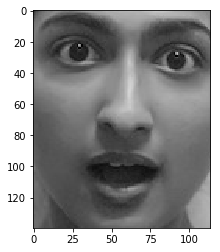

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13222.811926195704
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13177.039563154638
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13240.420421464854
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13151.708359012195
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13242.074096649612
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13543.902209033658
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13099.46023712859
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13118.592349171544
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13644.017495824803
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13259.066871545974
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13357.176419979422
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13198.832413350345
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13524.466207379088
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13701.388129888748
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13168.779996288722
FOR IMAGE  UY.FE1.152.tiff
Total_

In [76]:
test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/Test_Tiff/AK.SU1.11.tiff"
Cropped_Img = Load_Img(test_img_path, (65,85,179,225))
Display_Img(Cropped_Img)

Emotion_Label = Min_Max_Classifer(Images_Data, test_img_path, (65,85,179,225),  11, 11, 3)
print("Predicted Emotion: ", Emotion_Label)
print("Actual Emotion: ", Extract_Img_Label("AK.SU1.11.tiff"))

# test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/test/YM.SU3.60.tiff"
# Cropped_Img = Load_Img(test_img_path)
# Display_Img(Cropped_Img)



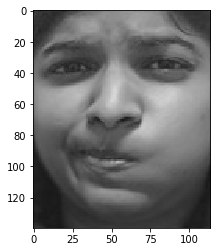

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13230.42780955513
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  13066.898027221698
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13407.420665654268
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  13122.848783166264
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13258.47782942736
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13224.737823120766
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  13002.500912348576
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  13116.862724586244
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13589.346282045397
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  13112.176580224976
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13182.838030497593
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13418.007217699873
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13771.798788598131
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13507.958033936673
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  13230.710231604768
FOR IMAGE  UY.FE1.152.tiff
Total_S

In [77]:
test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/Test_Tiff/PR.AN1.12.tiff"
Cropped_Img = Load_Img(test_img_path, (65,85,179,225))
Display_Img(Cropped_Img)

Emotion_Label = Min_Max_Classifer(Images_Data, test_img_path, (65,85,179,225),  11, 11, 3)
print("Predicted Emotion: ", Emotion_Label)
print("Actual Emotion: ", Extract_Img_Label("PR.AN1.12.tiff"))

# test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/dataset/KA.AN1.39.tiff"
# Cropped_Img = Load_Img(test_img_path)
# Display_Img(Cropped_Img)


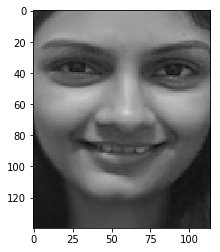

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13174.685943359285
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  12781.547799319633
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13197.978589179436
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  12762.78830446772
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  13070.877276409774
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13071.528767886986
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  12673.24409736217
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  12661.260098444822
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13222.009775963277
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  12809.555511656965
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13038.064266688565
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13136.783868944363
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13620.590128835272
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13350.365068449046
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  12918.87211351337
FOR IMAGE  UY.FE1.152.tiff
Total_Si

In [78]:
test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/Test_Tiff/EK.HA1.14.tiff"
Cropped_Img = Load_Img(test_img_path, (68,88,182,228))
Display_Img(Cropped_Img)

# test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/dataset/MK.HA3.118.tiff"
# Cropped_Img = Load_Img(test_img_path)
# Display_Img(Cropped_Img)

Emotion_Label = Min_Max_Classifer(Images_Data, test_img_path, (68,88,182,228),  11, 11, 3)
print("Predicted Emotion: ", Emotion_Label)
print("Actual Emotion: ", Extract_Img_Label("EK.HA1.14.tiff"))

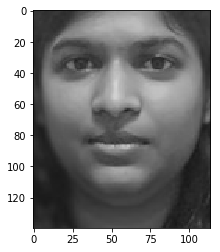

FOR IMAGE  MK.AN3.127.tiff
Total_Similarity:  13038.635132361765
FOR IMAGE  MK.NE1.113.tiff
Total_Similarity:  12874.061176496001
FOR IMAGE  YM.AN3.63.tiff
Total_Similarity:  13096.180920665578
FOR IMAGE  MK.SA1.119.tiff
Total_Similarity:  12816.546894336605
FOR IMAGE  KA.AN1.39.tiff
Total_Similarity:  12948.078443124581
FOR IMAGE  KA.SU2.37.tiff
Total_Similarity:  13090.107893547227
FOR IMAGE  YM.NE2.50.tiff
Total_Similarity:  12637.455774185128
FOR IMAGE  TM.HA2.181.tiff
Total_Similarity:  12787.35547245478
FOR IMAGE  NA.FE2.218.tiff
Total_Similarity:  13309.934051007996
FOR IMAGE  YM.NE3.51.tiff
Total_Similarity:  12777.607605697423
FOR IMAGE  MK.DI1.128.tiff
Total_Similarity:  13077.525959354587
FOR IMAGE  YM.AN2.62.tiff
Total_Similarity:  13143.546777437108
FOR IMAGE  KL.AN2.168.tiff
Total_Similarity:  13483.091205944065
FOR IMAGE  NA.AN2.212.tiff
Total_Similarity:  13430.040996487322
FOR IMAGE  KM.SA5.13.tiff
Total_Similarity:  12851.661226417229
FOR IMAGE  UY.FE1.152.tiff
Total_

In [79]:
test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/Test_Tiff/PR.NE1.13.tiff"
Cropped_Img = Load_Img(test_img_path, (68,88,182,228))
Display_Img(Cropped_Img)

# test_img_path = os.getcwd() + "/ml-face-jaffe-dataset-master/dataset/TM.NE3.179.tiff"
# Cropped_Img = Load_Img(test_img_path)
# Display_Img(Cropped_Img)

Emotion_Label = Min_Max_Classifer(Images_Data, test_img_path, (68,88,182,228),  11, 11, 3)
print("Predicted Emotion: ", Emotion_Label)
print("Actual Emotion: ", Extract_Img_Label("PR.NE1.13.tiff"))